In [13]:

import os
from torch.utils.data import Dataset, DataLoader
import glob
from torchvision.utils import make_grid
from skimage import io
from transformers import AutoProcessor, AutoTokenizer, CLIPModel
import warnings
from typing import Optional, Tuple, Union
import torch
from diffusers import UNet2DConditionModel
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
from data_load import FRLL
import torch.nn as nn
from deepface import DeepFace
from models import Generator, Discriminator
import argparse
from accelerate import Accelerator
import numpy as np
import itertools
import time
import datetime
import sys
import random
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable
from loss import CrossRoad



class Config:
    def __init__(self, epoch=0, n_epochs=300, dataset_name="amsl_rf", batch_size=24, lr=0.0001,
                 b1=0.5, b2=0.999, decay_epoch=100, n_cpu=8, img_height=256, img_width=256, 
                 channels=3, sample_interval=1000, checkpoint_interval=20, eval_interval=5):
        self.epoch = epoch
        self.n_epochs = n_epochs
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.decay_epoch = decay_epoch
        self.n_cpu = n_cpu
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.sample_interval = sample_interval
        self.checkpoint_interval = checkpoint_interval
        self.eval_interval = eval_interval

    def __str__(self):
        return str(self.__dict__)

# Example usage
opt = Config()
print(opt)



transform = transforms.Compose([        
        transforms.ToTensor(),
        transforms.Resize((opt.img_height,opt.img_width),antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                transforms.ToPILImage()
                               ])




from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
cond_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32",cache_dir='./cache').cuda()


def get_TMR(fmr_values,tmr_values,target_fmr=10):
    threshold_10_fmr = np.percentile(fmr_values, 100-target_fmr)
    true_match_rate = np.sum(tmr_values >= threshold_10_fmr) / len(tmr_values)

    print(f"TMR at {target_fmr}% FMR is: {true_match_rate:.2f}%")
    return true_match_rate

from AdaFace.face_alignment import align
from AdaFace.inference import load_pretrained_model, to_input
adaface = load_pretrained_model('ir_101').to('cuda')
def ada_embd(path,adaface):
    aligned_rgb_img = align.get_aligned_face(path)
    bgr_input = to_input(aligned_rgb_img)
    feature, _ = adaface(bgr_input.cuda())
    return feature


def get_embds(model,img,device,lamb=10.0,replicate=True):
    model=model.to(device)
    img=img.to(device)
    feats=[]
    for image in img:
        image=invTrans(image)
        inputs = processor(images=image, return_tensors="pt").to(device)
        feats.append(model.get_image_features(**inputs))
    feats=torch.stack(feats)
    return lamb*feats.repeat(1, 77, 1) if replicate else lamb*feats




with torch.inference_mode():
    def eval(adaface,model,loader):
        result=[]
        for comp_model in ["AdaFace"]:
            o1_o2,o1_i1,o2_i2,s1_imposter,s2_imposter,s1_tmr_at_01,s1_tmr_at_1,s1_tmr_at_5,s1_tmr_at_10=[],[],[],[],[],[],[],[],[]
            s2_tmr_at_01,s2_tmr_at_1,s2_tmr_at_5,s2_tmr_at_10=[],[],[],[]
            for i,batch in enumerate(tqdm(loader)):
                choice=random.choice([True,False])
                x='img1' if choice else 'img2'
                y='img2' if choice else 'img1'
                batch_={'B':batch['morphed_image'] ,'A':torch.cat([ batch[x],batch[y]],1)  }


                face_embd=get_embds(cond_model,batch_['B'].to('cuda'),'cuda')
                real_A = Variable(batch_["B"].type(torch.cuda.FloatTensor))
                real_B = Variable(batch_["A"].type(torch.cuda.FloatTensor))

                generated_faces = fake_B = model(real_A,face_embd)#generator(real_A,timestep=torch.tensor(0).cuda(),encoder_hidden_states=face_embd,return_dict=False)[0].detach()
                gen1,gen2=torch.split(generated_faces.data,3,1)
            

                for m,g1,g2,r1,r2 in zip(batch['morphed_image'],gen1,gen2,batch['img1'],batch['img2']):
                    invTrans(g1).save('g1.jpg')
                    invTrans(g2).save('g2.jpg')
                    invTrans(r1).save('r1.jpg')
                    invTrans(r2).save('r2.jpg')
                    invTrans(m).save('m.jpg')
                    
                    try:
                        
                        g1_embd=ada_embd('g1.jpg',adaface)
                        g2_embd=ada_embd('g2.jpg',adaface)
                        r1_embd=ada_embd('r1.jpg',adaface)
                        r2_embd=ada_embd('r2.jpg',adaface)
                        m_embd=ada_embd('m.jpg',adaface)

                        #if 
                        if (torch.cosine_similarity(g1_embd,r1_embd) +torch.cosine_similarity(g2_embd,r2_embd)).item()<(torch.cosine_similarity(g1_embd,r2_embd) +torch.cosine_similarity(g2_embd,r1_embd)).item():
                            g1_embd,g2_embd=g2_embd,g1_embd
                        o1_o2.append(torch.cosine_similarity(g1_embd,g2_embd)[0].item())
                        o1_i1.append(torch.cosine_similarity(g1_embd,r1_embd)[0].item())
                        o2_i2.append(torch.cosine_similarity(g2_embd,r2_embd)[0].item())
                        s1_imposter.append(torch.cosine_similarity(g1_embd,r2_embd)[0].item())
                        s2_imposter.append(torch.cosine_similarity(g2_embd,r1_embd)[0].item())
                    except:
                        continue


            s1_tmr_at_01,s1_tmr_at_1,s1_tmr_at_5,s1_tmr_at_10=get_TMR(s1_imposter,o1_i1,0.1),get_TMR(s1_imposter,o1_i1,1),get_TMR(s1_imposter,o1_i1,5),get_TMR(s1_imposter,o1_i1,10)
            s2_tmr_at_01,s2_tmr_at_1,s2_tmr_at_5,s2_tmr_at_10=get_TMR(s2_imposter,o2_i2,0.1),get_TMR(s2_imposter,o2_i2,1),get_TMR(s2_imposter,o2_i2,5),get_TMR(s2_imposter,o2_i2,10)
        return np.round(s1_tmr_at_10,3)*100,np.round(s2_tmr_at_10,3)*100

{'epoch': 0, 'n_epochs': 300, 'dataset_name': 'amsl_rf', 'batch_size': 24, 'lr': 0.0001, 'b1': 0.5, 'b2': 0.999, 'decay_epoch': 100, 'n_cpu': 8, 'img_height': 256, 'img_width': 256, 'channels': 3, 'sample_interval': 1000, 'checkpoint_interval': 20, 'eval_interval': 5}


# Load dataset

In [14]:
trainset = FRLL(train=True, transform=transform)
testset = FRLL(train=False,transform=transform)
dataloader=DataLoader(trainset,batch_size=opt.batch_size,drop_last=True,shuffle=True)
val_dataloader=DataLoader(testset,batch_size=4,drop_last=True,shuffle=True)

# Load Model Weights

In [15]:
generator = Generator(img_size=opt.img_width,in_channels=3,out_channels=6)
generator=torch.nn.DataParallel(generator)

generator.load_state_dict(torch.load(glob.glob('./saved_models/amsl_rf/generator_250*')[0]))
generator=generator.module.cuda()

# Evaluate

In [32]:
# eval(adaface,generator,val_dataloader)

# Plot Samples

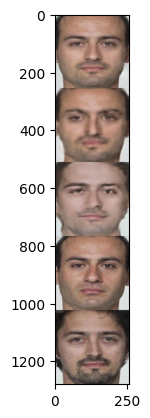

In [31]:
def sample_images(batches_done,model,scores=None):
    """Saves a generated sample from the validation set"""
    batch = next(iter(val_dataloader))
    batch={'B':batch['morphed_image'] ,'A':torch.cat([ batch['img1'],batch['img2']],1)  }
    face_embd=get_embds(model,batch['B'].to('cuda'),'cuda')
    real_A = Variable(batch["B"].type(torch.cuda.FloatTensor))
    real_B = Variable(batch["A"].type(torch.cuda.FloatTensor))
    fake_B = generator(real_A,face_embd)
    fakeb1,fakeb2=torch.split(fake_B.data,3,1)
    realb1,realb2=torch.split(real_B.data,3,1)
    img_sample = torch.cat(( real_A.data,fakeb1,fakeb2, realb1,realb2), -2)
    return img_sample


gen=sample_images(None,cond_model)
import matplotlib.pyplot as plt
plt.imshow(invTrans(gen[0]))
